<a href="https://colab.research.google.com/github/grand-cat-unknown/SVHNClassifier/blob/master/Trail1_BoxandDivide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##GET DATA
import os 

if 'train/' not in os.listdir():
  !wget -nc http://ufldl.stanford.edu/housenumbers/train.tar.gz 
  !wget -nc http://ufldl.stanford.edu/housenumbers/test.tar.gz 
  !wget -nc http://ufldl.stanford.edu/housenumbers/extra.tar.gz 

!git clone https://github.com/grand-cat-unknown/Street_View_House_Numbers SVHN

##ERROR IMAGES image = cv2.imread('train/30907.png')


File ‘train.tar.gz’ already there; not retrieving.

File ‘test.tar.gz’ already there; not retrieving.

File ‘extra.tar.gz’ already there; not retrieving.

fatal: destination path 'SVHN' already exists and is not an empty directory.


In [0]:
# from google.colab import files

# files.download('train.tar.gz')

In [0]:
##IMPORTS 
import os
import tarfile
import numpy as np
import h5py
import pickle

import pickle
import cv2
import json
import glob
import natsort  # natural sort (1, 2, 3, 4..., 100), instead of (1, 10, 100, 1000....)
from tqdm import tqdm

from SVHN.utils.hdf5datasetwriter import HDF5DatasetWriter
from SVHN.utils.aspect_aware_resize import AspectAwareResize
from SVHN.utils.extract_patch import ExtractPatch

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



## IMPORT GITHUB

if 'train' not in os.listdir():
  my_tar = tarfile.open('train.tar.gz')
  my_tar.extractall('')
  my_tar.close()
  !rm train.tar.gz


if 'test' not in os.listdir():
  my_tar = tarfile.open('test.tar.gz')
  my_tar.extractall('')
  my_tar.close()
  !rm test.tar.gz

if 'extra' not in os.listdir():
  my_tar = tarfile.open('extra.tar.gz')
  my_tar.extractall('')
  my_tar.close()
  !rm extra.tar.gz


extra_number = 100000

In [0]:

def get_box_data(index, hdf5_data):
    """
    get `left, top, width, height` of each picture
    :param index:
    :param hdf5_data:
    :return:
    """
    meta_data = dict()
    meta_data['label'] = []
    meta_data['top'] = []
    meta_data['left'] = []
    meta_data['height'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(int(hdf5_data[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = hdf5_data['/digitStruct/bbox'][index]
    hdf5_data[box[0]].visititems(print_attrs)
    return meta_data

def get_name(index, hdf5_data):
    name = hdf5_data["/digitStruct/name"]
    print(''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value]))



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# f = h5py.File('test/digitStruct.mat')

In [0]:

#MAKE SIZE AS 500

if "metadata.pkl"  not in os.listdir('/content/drive/My Drive/SVHN/'):
  labels_file = "train/digitStruct.mat"
  f = h5py.File(labels_file)
  metadata = []
  for j in range(len(os.listdir('train/'))- 3):
    print(j)
    metadata.append(get_box_data(j, f))
  pickle.dump(metadata, open("/content/drive/My Drive/SVHN/metadata.pkl", "wb"))

if "metadata_test.pkl" not in os.listdir('/content/drive/My Drive/SVHN/'):
  labels_file = "test/digitStruct.mat"
  f = h5py.File(labels_file)
  metadata_test = []
  for j in range(len(os.listdir('test/'))- 3):
    print(j)
    metadata_test.append(get_box_data(j, f))
  pickle.dump(metadata_test, open("/content/drive/My Drive/SVHN/metadata_test.pkl", "wb"))


if "metadata_extra.pkl" not in os.listdir('/content/drive/My Drive/SVHN/'):
  labels_file = "extra/digitStruct.mat"
  f = h5py.File(labels_file)
  metadata_extra = []
  for j in range(extra_number):
    print(j)
    metadata_extra.append(get_box_data(j, f))
  pickle.dump(metadata_extra, open("/content/drive/My Drive/SVHN/metadata_extra.pkl", "wb"))



In [0]:
metadata = pickle.load(open('/content/drive/My Drive/SVHN/metadata.pkl','rb'))
metadata_test = pickle.load(open('/content/drive/My Drive/SVHN/metadata_test.pkl','rb'))
metadata_extra = pickle.load(open('/content/drive/My Drive/SVHN/metadata_extra.pkl','rb'))

# metadata[20]

In [9]:
##ONLY A FEW EXIST
for j, i in enumerate(range(len(os.listdir('train/'))- 3)):
    t = len(metadata[i]["label"])
    if t >= 5:
        print(j, t)

4110 5
6738 5
15957 5
18262 5
18943 5
24040 5
24551 5
26698 5
29929 6
33228 5


In [0]:
final_labels = []

metadata = pickle.load(open("/content/drive/My Drive/SVHN/metadata.pkl", "rb"))
for i in range(len(os.listdir('train/'))- 5):
    t = metadata[i]["label"]
    temp_label = [int(x) for x in t]
    dt = len(temp_label) - 5
    if dt < 0:
        for ii in range(abs(dt)):
            temp_label.append(11)
    if dt > 0:
        del temp_label[-1]
    tt = len(t) if len(t)< 6 else 5
    temp_label.append(tt)
    final_labels.append(temp_label)
y = np.array(final_labels)
pickle.dump(y, open("/content/drive/My Drive/SVHN/svhn_labels.pkl", "wb"))


metadata_test = pickle.load(open("/content/drive/My Drive/SVHN/metadata_test.pkl", "rb"))

final_labels_test = []
for i in range(len(os.listdir('test/'))- 5):
    t = metadata_test[i]["label"]
    temp_label = [int(x) for x in t]
    dt = len(temp_label) - 5
    if dt < 0:
        for ii in range(abs(dt)):
            temp_label.append(11)
    if dt > 0:
        del temp_label[-1]
    tt = len(t) if len(t)< 6 else 5
    temp_label.append(tt)
    final_labels_test.append(temp_label)

y_test = np.array(final_labels_test)
pickle.dump(y_test, open("/content/drive/My Drive/SVHN/svhn_labels_test.pkl", "wb"))


metadata_extra = pickle.load(open("/content/drive/My Drive/SVHN/metadata_extra.pkl", "rb"))

final_labels_extra = []
for i in range(extra_number):
    t = metadata_extra[i]["label"]
    temp_label = [int(x) for x in t]
    dt = len(temp_label) - 5
    if dt < 0:
        for ii in range(abs(dt)):
            temp_label.append(11)
    if dt > 0:
        del temp_label[-1]
    tt = len(t) if len(t)< 6 else 5
    temp_label.append(tt)
    final_labels_extra.append(temp_label)

y_extra = np.array(final_labels_extra)
pickle.dump(y_extra, open("/content/drive/My Drive/SVHN/svhn_labels_extra.pkl", "wb"))

In [11]:
len(metadata_extra)

100000

In [0]:
image_paths = natsort.natsorted(glob.glob("train/*.png"))
test_paths = natsort.natsorted(glob.glob("test/*.png"))
extra_paths = natsort.natsorted(glob.glob("extra/*.png"))

metadata = pickle.load(open("/content/drive/My Drive/SVHN/metadata.pkl", "rb"))
labels = pickle.load(open("/content/drive/My Drive/SVHN/svhn_labels.pkl", "rb"))
metadata_test = pickle.load(open("/content/drive/My Drive/SVHN/metadata_test.pkl", "rb"))
labels_test = pickle.load(open("/content/drive/My Drive/SVHN/svhn_labels_test.pkl", "rb"))

metadata_extra = pickle.load(open("/content/drive/My Drive/SVHN/metadata_extra.pkl", "rb"))
labels_extra = pickle.load(open("/content/drive/My Drive/SVHN/svhn_labels_extra.pkl", "rb"))


In [13]:
# sl = glob.glob("test/*.png")[:]
# natsort.natsorted(sl)
labels_test[0]

array([ 5, 11, 11, 11, 11,  1])

In [0]:
# natsort.natsorted(glob.glob("test/*.png"))

In [0]:
def crop_bbox(img, metadata):
    shape = img.shape[:2]
    # print(shape)
    x = int(min(metadata["left"]))
    y = int(min(metadata["top"]))
    w = int(metadata["left"][-1] + metadata["width"][-1])
    h = int(max(metadata["top"]) + max(metadata["height"]))
    # print (x,y,w,h)
    dW = int(0.15*(w-x))
    dH = int(0.15*(h-y))
    
    x = 0 if (x - dW) < 0 else (x - dW)
    y = 0 if (y - dH) < 0 else (y - dH)
    w = shape[1] if (w + dW) > shape[1] else (w + dW)
    h = shape[0] if (h + dH) > shape[0] else (h + dH)
    # print (x,y,w,h)
    cropped = img[y:h, x:w]

    if cropped.shape[0] == 0 or cropped.shape[1] ==0:
      cropped = img
    # print(cropped.shape)
    return cv2.resize(cropped, (64, 64))

['test/1.png', 'test/2.png', 'test/3.png', 'test/4.png', 'test/5.png', 'test/6.png', 'test/7.png', 'test/8.png', 'test/9.png', 'test/10.png', 'test/11.png', 'test/12.png', 'test/13.png', 'test/14.png', 'test/15.png', 'test/16.png', 'test/17.png', 'test/18.png', 'test/19.png', 'test/20.png', 'test/21.png', 'test/22.png', 'test/23.png', 'test/24.png', 'test/25.png', 'test/26.png', 'test/27.png', 'test/28.png', 'test/29.png', 'test/30.png', 'test/31.png', 'test/32.png', 'test/33.png', 'test/34.png', 'test/35.png', 'test/36.png', 'test/37.png', 'test/38.png', 'test/39.png', 'test/40.png', 'test/41.png', 'test/42.png', 'test/43.png', 'test/44.png', 'test/45.png', 'test/46.png', 'test/47.png', 'test/48.png', 'test/49.png', 'test/50.png', 'test/51.png', 'test/52.png', 'test/53.png', 'test/54.png', 'test/55.png', 'test/56.png', 'test/57.png', 'test/58.png', 'test/59.png', 'test/60.png', 'test/61.png', 'test/62.png', 'test/63.png', 'test/64.png', 'test/65.png', 'test/66.png', 'test/67.png', 'te

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


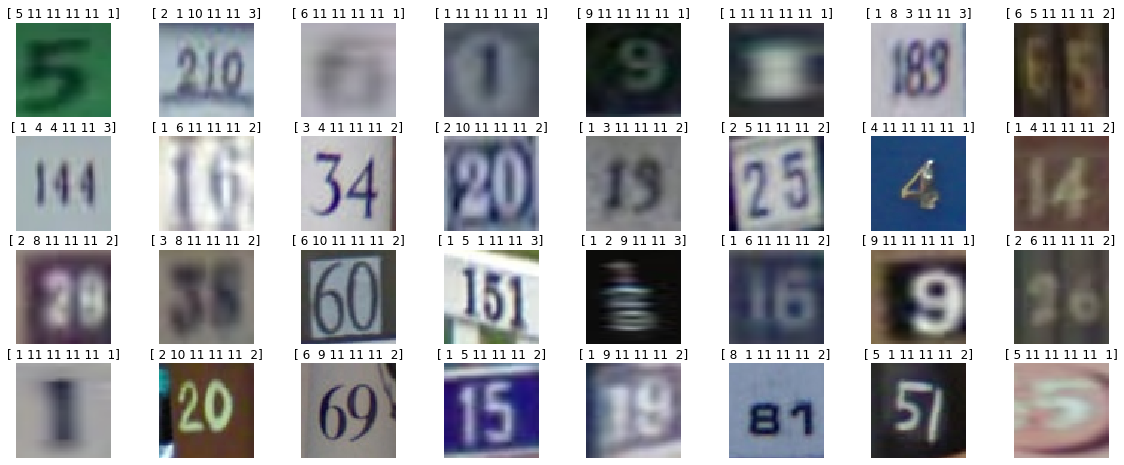

In [16]:
plt.figure(figsize=(20, 8))
import random

# x = random.randrange(7000)
x= 0
print(test_paths)

for idx, i in enumerate(range(x, x+32)):
    img = cv2.imread(test_paths[i])
    md = metadata_test[i]
    
    bb = crop_bbox(img, md)
    
    plt.subplot(4, 8, idx+1)
    plt.title(labels_test[i])
    plt.imshow(cv2.cvtColor(bb, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
plt.show()

In [0]:
Ptr, ytr, metatr = image_paths[:-2500], labels[:-2500], metadata[:-2500]
Pval, yval, metaval = image_paths[-2500:], labels[-2500:], metadata[-2500:]

In [18]:
os.listdir("/content/drive/My Drive/SVHN/classify")


['test.hdf5', 'val.hdf5', 'train.hdf5', 'extra.hdf5']

In [0]:
R, G, B = [], [], []


if 'train.hdf5' not in os.listdir("/content/drive/My Drive/SVHN/classify"):

  !rm classify/train.hdf5
  !rm classify/val.hdf5
  !rm classify/test.hdf5
  !mkdir /content/drive/My\ Drive/SVHN/classify
  !mkdir classify
  datasets = [("train", Ptr, ytr, metatr, "classify/train.hdf5"),
            ("val", Pval, yval, metaval, "classify/val.hdf5"),
              ("test", test_paths, labels_test, metadata_test, "classify/test.hdf5")]


  for (dtype, paths, labels, metas, outputs) in datasets:
      writer = HDF5DatasetWriter((len(paths), 64, 64, 3), outputs)
      # print(dtype)
      t = tqdm(zip(paths, labels, metas))
      for (path, label, meta) in t:
          # print(path)
          image = cv2.imread(path)
          image = crop_bbox(image, meta)
          
          if dtype == "train":
              (b, g, r) = cv2.mean(image)[:3]
              R.append(r)
              G.append(g)
              B.append(b)
              
          writer.add([image], [label])
      writer.close()
  !cp classify/train.hdf5 /content/drive/My\ Drive/SVHN/classify/train.hdf5
  print('copied train')
  !cp classify/test.hdf5 /content/drive/My\ Drive/SVHN/classify/test.hdf5
  print('copied test')
  !cp classify/val.hdf5 /content/drive/My\ Drive/SVHN/classify/val.hdf5
  print('copied val')

  

if 'extra.hdf5' not in os.listdir("/content/drive/My Drive/SVHN/classify"):
  !rm classify/extra.hdf5
  writer = HDF5DatasetWriter((30000, 64, 64, 3), "classify/extra.hdf5")
  t = tqdm(zip(extra_paths, labels_extra, metadata_extra))
  for (path, label, meta) in t:
      image = cv2.imread(path)
      image = crop_bbox(image, meta)

      (b, g, r) = cv2.mean(image)[:3]
      R.append(r)
      G.append(g)
      B.append(b)

      writer.add([image], [label])
  writer.close()
  !cp classify/extra.hdf5 /content/drive/My\ Drive/SVHN/classify/extra.hdf5



# M = {"R": np.mean(R), "G": np.mean(G), "B": np.mean(B)}
# pickle.dump(M, open("/content/drive/My Drive/SVHN/rgb_means.pkl", "wb"))

In [20]:
X = pickle.load(open("/content/drive/My Drive/SVHN/rgb_means.pkl", "rb"))
M = {"R": np.mean(R)+ X['R'], "G": np.mean(G) + X['G'] , "B": np.mean(B) + X['B']}
pickle.dump(M, open("/content/drive/My Drive/SVHN/rgb_means.pkl", "wb"))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
%tensorflow_version 1.x 
import h5py
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
%tensorflow_version 1.x 
from SVHN.model import SVHNNet
import pickle
import numpy as np
import cv2
from SVHN.utils.extract_patch import ExtractPatch
from SVHN.utils.mean_subtract import MeanSubtract
from SVHN.utils.generator import Generator

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
width = 54
height = 54
depth = 3
classes = 11
BS = 256
epochs = 50

In [24]:
model = SVHNNet.build(height, width, depth, classes)
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 54, 54, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 54, 54, 48)   3648        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 54, 54, 48)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 54, 54, 48)   192        

In [0]:
means = pickle.load(open("/content/drive/My Drive/SVHN/rgb_means.pkl", "rb"))

ep = ExtractPatch(width, height)
ms = MeanSubtract(means["R"], means["G"], means["B"])
preprocessors = [ep, ms]

def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

In [0]:
extra_gen = Generator("/content/drive/My Drive/SVHN/classify/extra.hdf5", BS, epochs, preprocessors)
train_gen = Generator("/content/drive/My Drive/SVHN/classify/train.hdf5", BS, epochs, preprocessors)
val_gen = Generator("/content/drive/My Drive/SVHN/classify/val.hdf5", BS, epochs, preprocessors)

# callbacks, add in earlystopping
callbacks = [TensorBoard("logs", batch_size=BS, write_images=True),
            LearningRateScheduler(exp_decay),
            EarlyStopping(monitor="val_loss", min_delta=0.05, patience=20)]

In [0]:
# model = load_model("/content/drive/My Drive/SVHN/svhn.h5")
opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


callbacks = [TensorBoard("logs", batch_size=BS, write_images=True),
            LearningRateScheduler(exp_decay)]

In [43]:
H = model.fit_generator(extra_gen.generate(), steps_per_epoch=extra_gen.n_img//BS,
                         epochs=epochs, callbacks=callbacks)

Epoch 1/50
117/117 [==============================] - 36s 305ms/step - loss: 8.1625 - dense_3_loss: 2.0011 - dense_4_loss: 2.3967 - dense_5_loss: 2.1343 - dense_6_loss: 0.4335 - dense_7_loss: 0.0534 - dense_8_loss: 1.1435 - dense_3_acc: 0.2839 - dense_4_acc: 0.0983 - dense_5_acc: 0.3988 - dense_6_acc: 0.9259 - dense_7_acc: 0.9995 - dense_8_acc: 0.3524


KeyError: ignored

In [0]:
model.save("/content/drive/My Drive/SVHN/svhn.h5")
model.save_weights("/content/drive/My Drive/SVHN/weights_model.h5")


In [48]:
from keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('/content/drive/My Drive/SVHN/best_svnh_weights-improvement-{epoch:02d}-{val_acc:.2f}.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks = [TensorBoard("logs", batch_size=BS, write_images=True),
            LearningRateScheduler(exp_decay)]
H = model.fit_generator(train_gen.generate(), validation_data=val_gen.generate(), steps_per_epoch=train_gen.n_img//BS,
                        validation_steps=val_gen.n_img//BS, epochs=10, callbacks=callbacks)

Epoch 1/10
120/120 [==============================] - 11s 93ms/step - loss: 7.1345 - dense_3_loss: 2.0170 - dense_4_loss: 2.3706 - dense_5_loss: 1.3168 - dense_6_loss: 0.2784 - dense_7_loss: 0.0302 - dense_8_loss: 1.1214 - dense_3_acc: 0.2773 - dense_4_acc: 0.1551 - dense_5_acc: 0.6949 - dense_6_acc: 0.9568 - dense_7_acc: 0.9999 - dense_8_acc: 0.5398 - val_loss: 7.2069 - val_dense_3_loss: 2.0201 - val_dense_4_loss: 2.3755 - val_dense_5_loss: 1.3400 - val_dense_6_loss: 0.3187 - val_dense_7_loss: 0.0281 - val_dense_8_loss: 1.1246 - val_dense_3_acc: 0.2778 - val_dense_4_acc: 0.1441 - val_dense_5_acc: 0.6875 - val_dense_6_acc: 0.9488 - val_dense_7_acc: 1.0000 - val_dense_8_acc: 0.5434
Epoch 2/10
 33/120 [=======>......................] - ETA: 7s - loss: 7.0959 - dense_3_loss: 2.0100 - dense_4_loss: 2.3639 - dense_5_loss: 1.2898 - dense_6_loss: 0.2702 - dense_7_loss: 0.0320 - dense_8_loss: 1.1301 - dense_3_acc: 0.2786 - dense_4_acc: 0.1681 - dense_5_acc: 0.7038 - dense_6_acc: 0.9583 - dense

KeyboardInterrupt: ignored

In [0]:
model.save("/content/drive/My Drive/SVHN/svhn.h5")
model.save_weights("/content/drive/My Drive/SVHN/weights_model.h5")


In [50]:
H = model.fit_generator(train_gen.generate(), validation_data=val_gen.generate(), steps_per_epoch=train_gen.n_img//BS,
                        validation_steps=val_gen.n_img//BS, epochs=30, callbacks=callbacks)

Epoch 1/30
120/120 [==============================] - 12s 99ms/step - loss: 7.1273 - dense_3_loss: 2.0166 - dense_4_loss: 2.3702 - dense_5_loss: 1.3161 - dense_6_loss: 0.2779 - dense_7_loss: 0.0271 - dense_8_loss: 1.1194 - dense_3_acc: 0.2773 - dense_4_acc: 0.1551 - dense_5_acc: 0.6949 - dense_6_acc: 0.9568 - dense_7_acc: 0.9999 - dense_8_acc: 0.5398 - val_loss: 7.2024 - val_dense_3_loss: 2.0197 - val_dense_4_loss: 2.3756 - val_dense_5_loss: 1.3398 - val_dense_6_loss: 0.3185 - val_dense_7_loss: 0.0252 - val_dense_8_loss: 1.1236 - val_dense_3_acc: 0.2778 - val_dense_4_acc: 0.1441 - val_dense_5_acc: 0.6875 - val_dense_6_acc: 0.9488 - val_dense_7_acc: 1.0000 - val_dense_8_acc: 0.5434
Epoch 2/30
120/120 [==============================] - 31s 256ms/step - loss: 7.1182 - dense_3_loss: 2.0215 - dense_4_loss: 2.3708 - dense_5_loss: 1.3074 - dense_6_loss: 0.2762 - dense_7_loss: 0.0270 - dense_8_loss: 1.1153 - dense_3_acc: 0.2771 - dense_4_acc: 0.1540 - dense_5_acc: 0.6977 - dense_6_acc: 0.9570 

KeyboardInterrupt: ignored

In [0]:
# from google.colab import files
# files.download('svhn.h5') 

In [0]:
%tensorflow_version 1.x
from keras.models import load_model

import pickle
import cv2
import h5py
import glob
import numpy as np
import natsort

from SVHN.utils.generator import Generator
from SVHN.utils.simple_resize import SimpleResize
from SVHN.utils.mean_subtract import MeanSubtract

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:

# model = load_model("svhn.h5")

# model= load_model("/content/drive/My Drive/SVHN/svhn.h5")
# model.load_weights("/content/drive/My Drive/SVHN/weights_model.h5")


with h5py.File("/content/drive/My Drive/SVHN/classify/test.hdf5", "r") as f:
    labels = f["labels"][()]
# print((labels)[-10:])
means = pickle.load(open("/content/drive/My Drive/SVHN/rgb_means.pkl", "rb"))
sr = SimpleResize(54, 54)
ms = MeanSubtract(means["R"], means["G"], means["B"])
preprocessors = [sr, ms]
gen = Generator("/content/drive/My Drive/SVHN/classify/test.hdf5", BS, 1, preprocessors)

In [0]:
predictions = model.predict_generator(gen.generate(), steps=(gen.n_img//BS)+1) #steps+1 because not enough steps to loop all data
gen.close()

In [62]:
# print (predictions)
print(np.argmax(predictions[0], axis=-1))

[0 0 0 ... 0 0 0]


In [60]:
accuracy = 0.0
print("Accuracies for every digits:")
for i in range(6):
    pred = predictions[i]
    pred = np.argmax(pred, axis=-1)
    label = labels[:, i]
    
    acc = accuracy_score(label, pred)
    
    if i != 5:
        print("Digit {}: {:.2f}".format(i+1, acc))
    else:
        print("Sequence length: {:.2f}\n".format(acc))
        
    accuracy += acc
        
print("Overall accuracy: {:.2f}".format(accuracy/6))

Accuracies for every digits:
Digit 1: 0.00
Digit 2: 0.11
Digit 3: 0.02
Digit 4: 0.00
Digit 5: 0.00
Sequence length: 0.19

Overall accuracy: 0.05


In [0]:
%matplotlib inline

test_paths = natsort.natsorted(glob.glob("test/*.png"))

idxs = np.random.choice(len(test_paths), size=32)

plt.figure(figsize=(20, 8))
for n, i in enumerate(idxs):
    img = cv2.imread(test_paths[i])
    
    pred = []
    for p in predictions:
        temp = np.argmax(p, axis=-1)
        pred.append(temp[i])
        
    plt.subplot(4, 8, n+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(pred)
    
plt.show()